# Homework 2
By Avanth Pakanati


Question 1: Graph of Hospitals That Filed More Than One Report

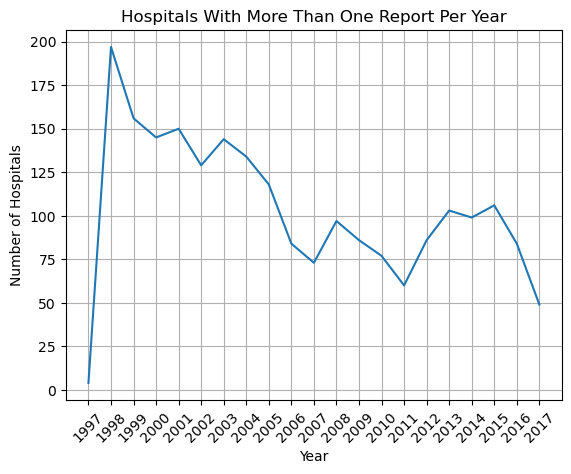

In [128]:
#| echo: false
#1 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter('ignore')

HCRIS = pd.read_csv('/Users/avanthpakanati/Desktop/ECON:HLTH Research Seminar /Homework2-/data/Output/HCRIS.csv')

# Convert 'fy_start' to datetime FORMAT
HCRIS['fy_start'] = pd.to_datetime(HCRIS['fy_start'], errors='coerce')
HCRIS['year'] = HCRIS['fy_start'].dt.year

# Count hospitals that filed more than one report in the same year
hospital_counts = HCRIS.groupby(['provider_number', 'year']).size().reset_index(name='report_count')
multiple_reports = hospital_counts[hospital_counts['report_count'] > 1]

# Count number of hospitals per year
hospitals_over_time = multiple_reports.groupby('year')['provider_number'].nunique()

# Plot the results
plt.figure()
plt.plot(hospitals_over_time.index, hospitals_over_time.values)
plt.xlabel('Year')
plt.xticks(hospitals_over_time.index, rotation=45) 
plt.ylabel('Number of Hospitals')
plt.title('Hospitals With More Than One Report Per Year')
plt.grid(True)
plt.show()



Question 2

In [126]:
#Question 2

#| echo: false

#Removing duplicate reports
unique_hospitals = HCRIS.drop_duplicates(subset=['provider_number', 'year'])

#Count of number of unique hospital IDs
unique_hospital_count = unique_hospitals['provider_number'].nunique()

print(f"Number of Unique Hospital IDs: {unique_hospital_count}")



Number of Unique Hospital IDs: 9323


Question 3 - For the graph, I dropped all negative values and outliers (Top 5% values)

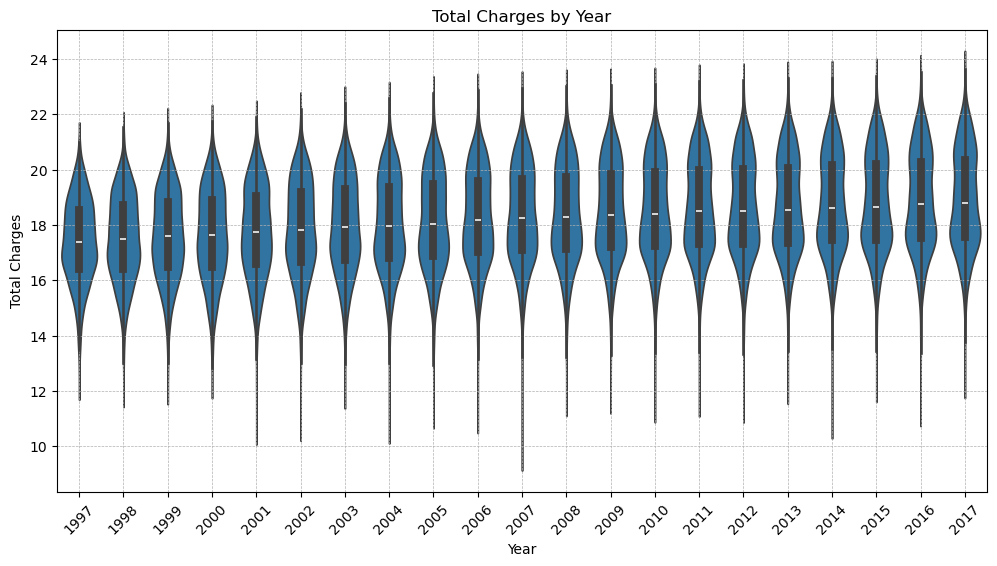

In [129]:
#Question 3 
#| echo: false
HCRIS['tot_charges'] = pd.to_numeric(HCRIS['tot_charges'], errors='coerce')

# Convert tot_charges to numeric
HCRIS['tot_charges'] = pd.to_numeric(HCRIS['tot_charges'], errors='coerce')

#Remove rows with missing values, negative values, and outliers
charges_by_year = HCRIS[['year', 'tot_charges']].dropna()
charges_by_year = charges_by_year[charges_by_year['tot_charges'] >= 0]


#creating upper bound limit
charges_by_year = charges_by_year[charges_by_year['tot_charges'] >= 10000]
upper_bound = summary_stats['95%'] if '95%' in summary_stats else summary_stats['max']
charges_by_year = charges_by_year[charges_by_year['tot_charges'] <= upper_bound]
charges_by_year['log_tot_charges'] = np.log(charges_by_year['tot_charges'] + 1)




# Plot violin plot
plt.figure(figsize=(12, 6))
sns.violinplot(x='year', y='log_tot_charges', data=charges_by_year)
plt.title("Total Charges by Year")
plt.xlabel("Year")
plt.ylabel("Total Charges")
plt.xticks(rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


Question 4

count    5.907300e+04
mean              inf
std               NaN
min     -8.110641e+05
25%      4.765466e+03
50%      7.091094e+03
75%      1.020399e+04
max               inf
Name: estimated_price, dtype: float64


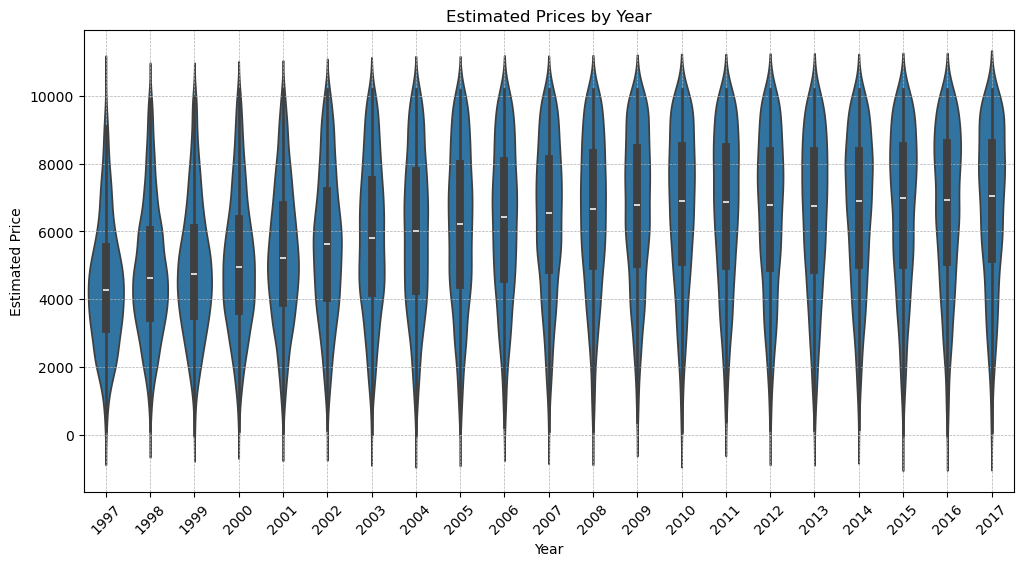

In [ ]:
#Question 4
#| echo: false
#Converting columns to numeric 
numeric_columns = [
    'tot_discounts', 'tot_charges', 'ip_charges', 'icu_charges', 'ancillary_charges',
    'tot_mcare_payment', 'tot_discharges', 'mcare_discharges'
]
HCRIS[numeric_columns] = HCRIS[numeric_columns].apply(pd.to_numeric, errors='coerce')


# Remove missing values
hcris_clean = HCRIS[['year'] + numeric_columns].dropna()

# Calculate estimated price
discount_factor = 1 - hcris_clean['tot_discounts'] / hcris_clean['tot_charges']
price_num = (hcris_clean['ip_charges'] + hcris_clean['icu_charges'] + hcris_clean['ancillary_charges']) * discount_factor - hcris_clean['tot_mcare_payment']
price_denom = hcris_clean['tot_discharges'] - hcris_clean['mcare_discharges']
hcris_clean['estimated_price'] = price_num / price_denom

#removing outliers and negatives

summary_stats = hcris_clean['estimated_price'].describe()
print(summary_stats)

upper_bound = summary_stats['75%'] if '75%' in summary_stats else summary_stats['max']
hcris_clean = hcris_clean[hcris_clean['estimated_price'] <= upper_bound]
hcris_clean = hcris_clean[hcris_clean['estimated_price'] > 0]

#Plot violin plot 
plt.figure(figsize=(12, 6))
sns.violinplot(x='year', y='estimated_price', data=hcris_clean)
plt.title("Estimated Prices by Year")
plt.xlabel("Year")
plt.ylabel("Estimated Price")
plt.xticks(rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()




Question 5

In [111]:
#Q5
hcris_2012 = HCRIS[HCRIS['year'] == 2012]

#Calculating estimated price for 2012
hcris_2012['discount_factor'] = 1 - hcris_2012['tot_discounts'] / hcris_2012['tot_charges']
hcris_2012['price_num'] = (
    (hcris_2012['ip_charges'] + hcris_2012['icu_charges'] + hcris_2012['ancillary_charges'])
    * hcris_2012['discount_factor'] - hcris_2012['tot_mcare_payment'])
hcris_2012['price_denom'] = hcris_2012['tot_discharges'] - hcris_2012['mcare_discharges']
hcris_2012['price'] = hcris_2012['price_num'] / hcris_2012['price_denom']

# Cleaning the  data
hcris_2012 = hcris_2012[(hcris_2012['price_denom'] > 100) & (hcris_2012['price_num'] > 0) & (hcris_2012['price'] > 0)]
hcris_2012 = hcris_2012[hcris_2012['beds'] > 30]
hcris_2012 = hcris_2012[hcris_2012['price'] < 100000]  

#NA payments
hcris_2012['hvbp_payment'] = hcris_2012['hvbp_payment'].fillna(0)
hcris_2012['hrrp_payment'] = hcris_2012['hrrp_payment'].fillna(0).abs()

#Defining penalty 
hcris_2012['penalty'] = (hcris_2012['hvbp_payment'] + hcris_2012['hrrp_payment'] < 0).astype(int)


# Calculate average price for penalized vs non-penalized hospitals
mean_penalized = round(hcris_2012.loc[hcris_2012['penalty'] == 1, 'price'].mean(), 2)
mean_non_penalized = round(hcris_2012.loc[hcris_2012['penalty'] == 0, 'price'].mean(), 2)

print(f"Average price for penalized hospitals in 2012: {mean_penalized}")
print(f"Average price for non-penalized hospitals in 2012: {mean_non_penalized}")




Average price for penalized hospitals in 2012: 10087.73
Average price for non-penalized hospitals in 2012: 9388.11


Question 6

In [120]:
#Question 6
hcris_2012['beds_quartile'] = pd.qcut(hcris_2012['beds'], 4, labels=[1, 2, 3, 4])

# Create indicator variables for each quartile
for i in range(1, 5):
    hcris_2012[f'quartile_{i}'] = (hcris_2012['beds_quartile'] == i).astype(int)


# Calculate average price for treated and control groups within each quartile
Avg_per_group = []
for i in range(1, 5):
    treated_mean = hcris_2012.loc[(hcris_2012[f'quartile_{i}'] == 1) & (hcris_2012['penalty'] == 1), 'price'].mean()
    control_mean = hcris_2012.loc[(hcris_2012[f'quartile_{i}'] == 1) & (hcris_2012['penalty'] == 0), 'price'].mean()
    Avg_per_group.append({'Quartile': i, 'Penalized_Mean_Price': round(treated_mean, 2), 'Non_Penalized_Mean_Price': round(control_mean, 2)})

results_df = pd.DataFrame(Avg_per_group)
print(results_df)







   Quartile  Penalized_Mean_Price  Non_Penalized_Mean_Price
0         1               7558.71                   7408.88
1         2               9444.01                   8387.51
2         3              10956.85                   9429.43
3         4              12678.08                  12308.15


Question 7

In [125]:

beds_quartile = pd.get_dummies(hcris_2012['beds_quartile'], prefix='beds_quartile').iloc[:, :-1] * 1
beds_quartile = beds_quartile.sub(beds_quartile.mean(axis=0), axis=1)


X = beds_quartile.values
y = hcris_2012['price'].values
D = hcris_2012['penalty'].values

cm = CausalModel(Y=y, D=D, X=X)


results = pd.DataFrame(index=['ATE', 'SE'], columns=['INV', 'MAH', 'IPW', 'OLS'])





#Inverse Weighting
cm.est_via_matching(weights='inv', matches=1, bias_adj=True)
results.loc['ATE', 'INV'] = cm.estimates['matching']['ate']
results.loc['SE', 'INV'] = cm.estimates['matching']['ate_se']

#Mahlanobis
cm.est_via_matching(weights='maha', matches=1, bias_adj=True)
results.loc['ATE', 'MAH'] = cm.estimates['matching']['ate']
results.loc['SE', 'MAH'] = cm.estimates['matching']['ate_se']


#Propensity
cm.est_propensity()
cm.est_via_weighting()
results.loc['ATE', 'IPW'] = cm.estimates['weighting']['ate']
results.loc['SE', 'IPW'] = cm.estimates['weighting']['ate_se']

#OLS
cm.est_via_ols(adj=2) 
results.loc['ATE', 'OLS'] = cm.estimates['ols']['ate']
results.loc['SE', 'OLS'] = cm.estimates['ols']['ate_se']






print(results)





            INV         MAH         IPW         OLS
ATE  774.168691  774.168691  774.168691  774.168691
SE   249.737628  249.737628  248.914803  248.696831


In [115]:
from causalinference import CausalModel
#Question 7 - Nearest Neighbor Match - Mahalanobis 

# Select relevant variables
X = hcris_2012[['beds_quartile']].values
y = hcris_2012['price'].values
treatment = hcris_2012['penalty'].values

# Create Causal Model
causal_model = CausalModel(Y=y, D=treatment, X=X)

# Perform Nearest Neighbor Matching (1-to-1) with Inverse Variance Distance
causal_model.est_via_matching(matches=1, bias_adj=True)

# Print the Average Treatment Effect (ATE)
print("ATE using Nearest Neighbor Matching (Inverse Variance Distance):")
print(causal_model.estimates)

ATE using Nearest Neighbor Matching (Inverse Variance Distance):

Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE    774.169    249.738      3.100      0.002    284.683   1263.654
           ATC    780.816    249.892      3.125      0.002    291.028   1270.604
           ATT    748.376    249.572      2.999      0.003    259.215   1237.537



Question 8
- The different treatment effect estimators are exactly identical. This is expected. 

Question 9
- No I do not think we've estimated a causal effect. We have purely adjusted our model for bed size. There are lots of other factors that would need to be controlled for in order to estimate a causal effect of the penalty. Patient acuity.

Question 10 
- Overall, I had a difficult experience working with this data, but learned a lot of valuable lessons along the way. When I have worked with data in other classes in the past, I have always been given a nice, clean dataset and am able to begin analyzing the dataset easily. When working with this data, the bulk of the work is cleaning and merging the data, which I definitely found to be challenging. However, I definitely recognize how important these skills are. When working with data in the real world, it is rarely ever clean, so I am really happy to be getting experience with this. 
